**QuickLook tools on notebooks**

In [2]:
%matplotlib widget

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend("matplotlib")
from pfs.drp.stella.utils import addPfsCursor, showAllSpectraAsImage, showDetectorMap
from pfs.drp.stella import SpectrumSet
from pfs.drp.stella.subtractSky1d import subtractSky1d
from pfs.utils.fiberids import FiberIds
from pfs.datamodel import PfsDesign, FiberStatus, TargetType
from pfs.datamodel import PfsFiberNorms
from pfs.drp.stella.readLineList import ReadLineListTask, ReadLineListConfig
from pfs.drp.stella.subtractSky1d import subtractSky1d
from pfs.datamodel.target import Target

from lsst.afw.math import statisticsStack, MEANCLIP, StatisticsControl
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["font.size"] = 12         
plt.rcParams["xtick.direction"] = "in" 
plt.rcParams["ytick.direction"] = "in" 
plt.rcParams["xtick.top"] = True
plt.rcParams["xtick.bottom"] = True    
plt.rcParams["ytick.left"] = True      
plt.rcParams["ytick.right"] = True     
plt.rcParams["xtick.major.size"] = 8.0 
plt.rcParams["ytick.major.size"] = 8.0 
plt.rcParams["xtick.major.width"] = 1.0
plt.rcParams["ytick.major.width"] = 1.0
plt.rcParams["xtick.minor.size"] = 4.0 
plt.rcParams["ytick.minor.size"] = 4.0 
plt.rcParams["xtick.minor.width"] = 0.7
plt.rcParams["ytick.minor.width"] = 0.7
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams["xtick.labelsize"] = 12   
plt.rcParams["ytick.labelsize"] = 12   
plt.rcParams["axes.labelsize"] = 12   
plt.rcParams["figure.facecolor"] = 'white'

In [15]:
##############################################################
# Please run this cell before the night operation starts !! ##
##############################################################

######################################
### do not change unless necessary ###
datastore = "/work/datastore"
baseCollection = "u/obsproc/s25a/20250520b"
utc_today = datetime.utcnow().strftime('%Y-%m-%d')
### do not change unless necessary ###
######################################

# check sky-subtracted 2D image

In [16]:
###################
## specify visit ##
###################
#visit = 122803
visit = 126714

#######################################
## specify spectrograph (1, 2, 3, 4) ##
#######################################
spectrograph = 1

#######################################
## specify arm ("b", "r", "n", "m") ##
#######################################
## note: please specify "r" for LowRes and "m" for MidRes ##
arm = "r"
#arm = "m"

dataId = dict(visit=visit, spectrograph=spectrograph, arm=arm)


print(f"showing sky-subtracted 2D images (may take a while) ...")
collections = [os.path.join(baseCollection, f"{visit}")]
butler = Butler("/work/datastore", collections=collections)

pfsConfig = butler.get("pfsConfig", dataId)
exp = butler.get("calexp", dataId)
detMap = butler.get("detectorMap", dataId)
pfsArm = butler.get("pfsArm", dataId)
pfsMerged = butler.get("pfsMerged", visit=visit)

## change this to True if you have specific fiberIds to hilight otherwise observatory fillers are highlighted ##
## you can commented out "showDetectorMap(...)" below if you don't like to highlight fibers ##

if False:
    fiberIds = [700, 800, 900]
else:
    fiberIds = [fid for fid, tt, obcode in zip(pfsConfig.fiberId, pfsConfig.targetType, pfsConfig.obCode) if (tt == TargetType.SCIENCE) * ("observatoryfiller_" in obcode)]

subtractSpectrum=False
subtractSky=True

if pfsConfig.obstime[:10] != utc_today:
    print("Please look at visits of today!")
else:
    if subtractSpectrum or subtractSky:
        pfsArm = butler.get("pfsArm", dataId)
        if subtractSky:
            from pfs.drp.stella.subtractSky1d import subtractSky1d
            sky1d = butler.get("sky1d", dataId)
            subtractSky1d(pfsArm, pfsConfig, sky1d)
            _flux = pfsArm.flux
            pfsArm.flux = pfsArm.sky
        spectra = SpectrumSet.fromPfsArm(pfsArm)
        profiles = butler.get("fiberProfiles", dataId)
        traces = profiles.makeFiberTracesFromDetectorMap(detMap)
        image = spectra.makeImage(exp.getDimensions(), traces)
        del spectra
        if subtractSky:
            pfsArm.flux = _flux; del _flux
        exp.image -= image
    
    fig = 1; plt.close(fig); fig = plt.figure(fig, figsize=(10,10))
    disp = afwDisplay.Display(fig)
    disp.scale('asinh', 'zscale', Q=1)
    disp.mtv(exp, title=f"{'calexp %(visit)d %(arm)s%(spectrograph)d' % dataId}\n{butler.collections[0]}")
    showDetectorMap(disp, pfsConfig, detMap, fiberIds=fiberIds, width=4, alpha=0.5, xcen=0)
    addPfsCursor(disp, detMap)
    #disp.zoom(64, 1000, 3700)
    

showing sky-subtracted 2D images (may take a while) ...
Please look at visits of today!


# check 1D extracted spectra

## check information of a specific fiber

In [6]:
########################################################################
## changing if False you can also specify obCode to show the spectrum ##
########################################################################
if True:
    fiberId = 418
    targetType = TargetType(pfsConfig.select(fiberId=fiberId).targetType[0])
    fiberStatus = FiberStatus(pfsConfig.select(fiberId=fiberId).fiberStatus[0])
    proposalId = pfsConfig.select(fiberId=fiberId).proposalId[0]
    obCode = pfsConfig.select(fiberId=fiberId).obCode[0]
    objId = pfsConfig.select(fiberId=fiberId).objId[0]
else:
    obCode = "observatoryfiller_ps1dr2_170662156319371979_L"
    fiberId = pfsConfig[pfsConfig.obCode==obCode].fiberId[0]
    targetType = TargetType(pfsConfig.select(fiberId=fiberId).targetType[0])
    fiberStatus = FiberStatus(pfsConfig.select(fiberId=fiberId).fiberStatus[0])
    proposalId = pfsConfig.select(fiberId=fiberId).proposalId[0]
    objId = pfsConfig.select(fiberId=fiberId).objId[0]

print(f"fiberId={fiberId}")
print(f"  targetType={targetType}")
print(f"  fiberStatus={fiberStatus}")
print(f"  proposalId={proposalId}")
print(f"  obCode={obCode}")
print(f"  objId={objId}")

fiberId=418
  targetType=SCIENCE
  fiberStatus=GOOD
  proposalId=S25A-OT02
  obCode=_cos_3419784627592655277
  objId=3419784627592655277


## check a single spectrum

418 3419784627592655277 _cos_3419784627592655277


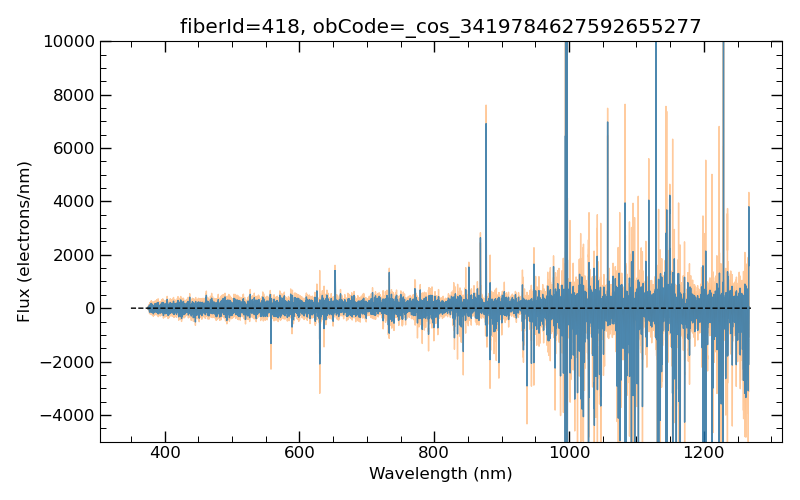

In [7]:
if pfsConfig.obstime[:10] != utc_today:
    print("Please look at visits of today!")
else:
    print(fiberId, objId, obCode)
    
    pfsMergedSel = pfsMerged.select(pfsConfig, fiberId=fiberId)
    wav = pfsMergedSel.wavelength[0]
    flx = pfsMergedSel.flux[0]
    msk = pfsMergedSel.mask[0]
    var = pfsMergedSel.variance[0]
    err = np.sqrt(var)
    
    bad = msk & pfsMergedSel.flags.get("NO_DATA", "SAT", "BAD", "CR") != 0
    good = ~bad
    
    fig,axe=plt.subplots(figsize=(8,5), tight_layout=True)
    axe.set_xlabel(f"Wavelength (nm)")
    axe.set_ylabel(f"Flux (electrons/nm)")
    axe.set_title(f"fiberId={fiberId}, obCode={obCode}")
    axe.plot(wav[good], flx[good], ls="solid", lw=1, color='C0', alpha=0.8)
    #axe.plot(wav, err, ls="solid", lw=1, color='C1')
    axe.fill_between(wav[good], flx[good]-err[good], flx[good]+err[good], color='C1', alpha=0.4)
    axe.plot(wav, np.zeros(len(wav)), ls="dashed", lw=1, color="k")    
    
    axe.set_ylim(-5000, 10000)


## check multiple spectra

[412, 418, 437] [np.int64(3419784627592658392), np.int64(3419784627592655277), np.int64(3419780229546139097)] [np.str_('_cos_3419784627592655277'), np.str_('_cos_3419784627592655277'), np.str_('_cos_3419784627592655277')]


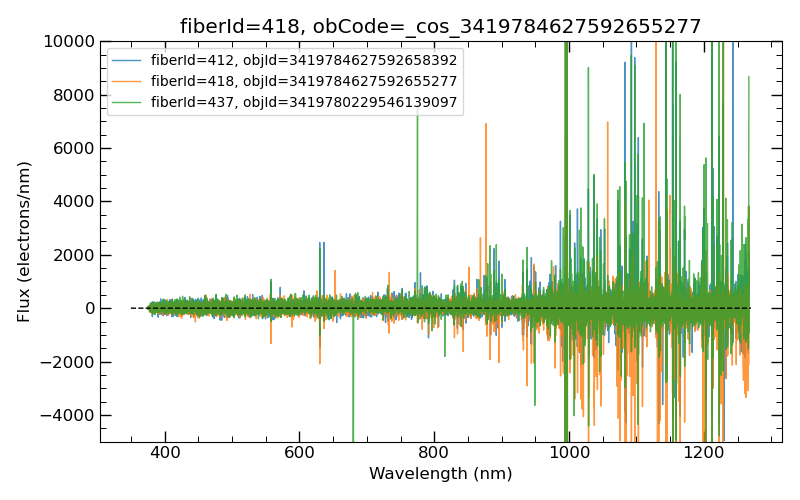

In [8]:
#########################################################################
## change a list of fiberIds to show multiple spectra at the same time ##
#########################################################################

fiberIds = [412, 418, 437]
objIds = [pfsConfig.select(fiberId=fid).objId[0] for fid in fiberIds]
obCodes = [pfsConfig.select(fiberId=fiberId).obCode[0] for fid in fiberIds]

if pfsConfig.obstime[:10] != utc_today:
    print("Please look at visits of today!")
else:
    print(fiberIds, objIds, obCodes)
    
    fig,axe=plt.subplots(figsize=(8,5), tight_layout=True)
    
    for fid, oid, ocode in zip(fiberIds, objIds, obCodes):
        pfsMergedSel = pfsMerged.select(pfsConfig, fiberId=fid)
        wav = pfsMergedSel.wavelength[0]
        flx = pfsMergedSel.flux[0]
        msk = pfsMergedSel.mask[0]
        var = pfsMergedSel.variance[0]
        err = np.sqrt(var)
        
        bad = msk & pfsMergedSel.flags.get("NO_DATA", "SAT", "BAD", "CR") != 0
        good = ~bad
        
        axe.set_xlabel(f"Wavelength (nm)")
        axe.set_ylabel(f"Flux (electrons/nm)")
        axe.set_title(f"fiberId={fiberId}, obCode={obCode}")
        axe.plot(wav[good], flx[good], ls="solid", lw=1, alpha=0.8, label=f"fiberId={fid}, objId={oid}")
        #axe.plot(wav, err, ls="solid", lw=1, color='C1')
        #axe.fill_between(wav[good], flx[good]-err[good], flx[good]+err[good], color='C1', alpha=0.4)
    
    axe.legend(loc="upper left", fontsize=10)
    axe.plot(wav, np.zeros(len(wav)), ls="dashed", lw=1, color="k")        
    axe.set_ylim(-5000, 10000)


# combine multiple visits

In [9]:
#####################################################################
## specify a list of visits to combine, spectrograph, and arm here ##
#####################################################################
visits = [126714, 126715, 126716, 126717]

#######################################
## specify spectrograph (1, 2, 3, 4) ##
#######################################
spectrograph = 1

#######################################
## specify arm ("b", "r", "n", "m") ##
#######################################
## note: please specify "r" for LowRes and "m" for MidRes ##
arm = "r"
#arm="m"

In [10]:
collections = [os.path.join(baseCollection, f"{visits[0]}")]
butlerCombine = Butler("/work/datastore", collections=collections)
pfsConfig = butlerCombine.get("pfsConfig", visit=visit)

## check sky-subtracted 2D image

In [11]:
subtractSpectrum=False
subtractSky=True

exposureList = []

print(f"stacking sky-subtracted 2D images (should take a while) ...")

if pfsConfig.obstime[:10] != utc_today:
    print("Please look at visits of today!")
else:
    for visit in visits:
        collections = [os.path.join(baseCollection, f"{visit}")]
        butlerCombine = Butler("/work/datastore", collections=collections)
        dataId = dict(visit=visit, spectrograph=spectrograph, arm=arm)
        print(dataId)
    
        pfsConfig = butlerCombine.get("pfsConfig", dataId)
        exp = butlerCombine.get("calexp", dataId)
        #detMap = butlerCombine.get("detectorMap_calib", dataId)
        detMap = butlerCombine.get("detectorMap", dataId)
        pfsArm = butlerCombine.get("pfsArm", dataId)
        pfsMerged = butlerCombine.get("pfsMerged", dataId)
    
        if subtractSpectrum or subtractSky:
            pfsArm = butlerCombine.get("pfsArm", dataId)
            if subtractSky:
                from pfs.drp.stella.subtractSky1d import subtractSky1d
                sky1d = butlerCombine.get("sky1d", dataId)
                subtractSky1d(pfsArm, pfsConfig, sky1d)
                _flux = pfsArm.flux
                pfsArm.flux = pfsArm.sky
            spectra = SpectrumSet.fromPfsArm(pfsArm)
            profiles = butlerCombine.get("fiberProfiles", dataId)
            traces = profiles.makeFiberTracesFromDetectorMap(detMap)
            image = spectra.makeImage(exp.getDimensions(), traces)
            del spectra
            if subtractSky:
                pfsArm.flux = _flux; del _flux
            exp.image -= image
        exposureList.append(exp)
        
    control = StatisticsControl()
    control.setAndMask(exposureList[0].mask.getPlaneBitMask(["BAD", "CR", "SAT", "NO_DATA"]))
    stack = exposureList[0].clone()
    stack.maskedImage = statisticsStack([exp.maskedImage for exp in exposureList], MEANCLIP, control)

stacking sky-subtracted 2D images (should take a while) ...
{'visit': 126714, 'spectrograph': 1, 'arm': 'r'}
{'visit': 126715, 'spectrograph': 1, 'arm': 'r'}
{'visit': 126716, 'spectrograph': 1, 'arm': 'r'}
{'visit': 126717, 'spectrograph': 1, 'arm': 'r'}


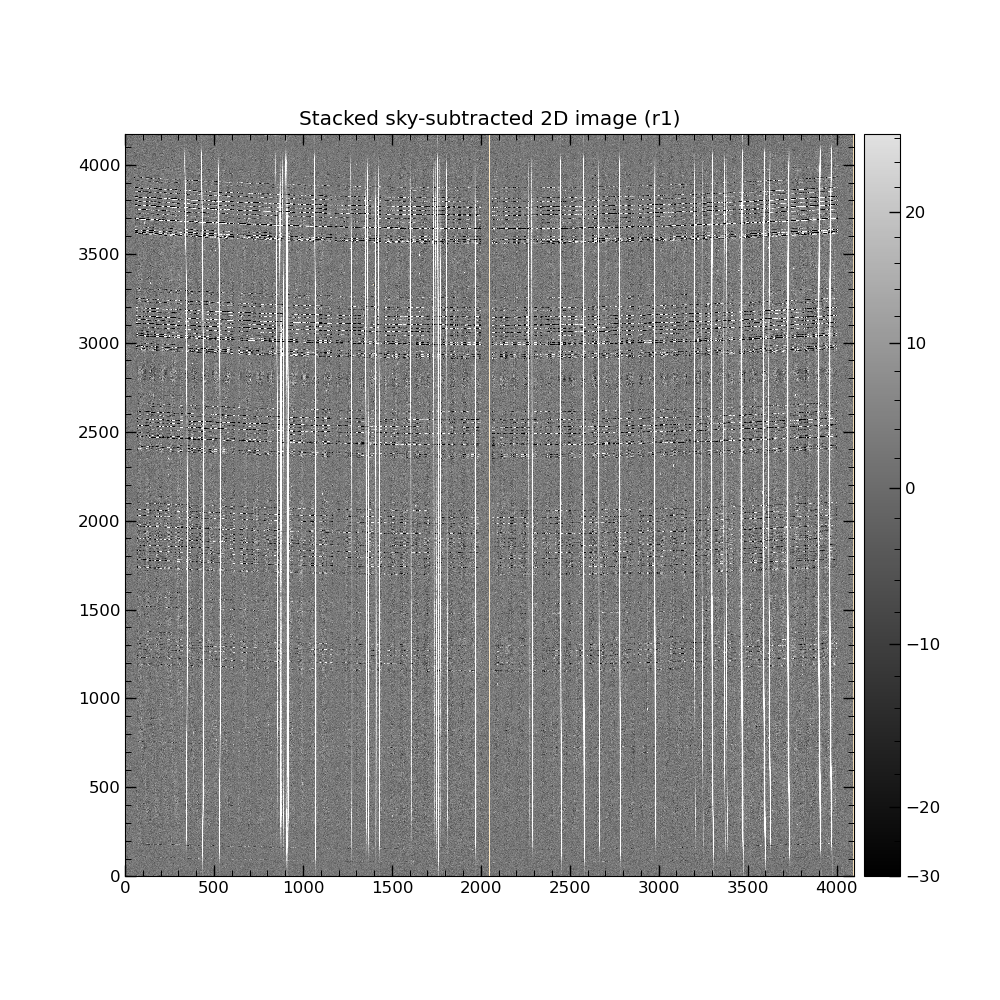

In [12]:
fig = 1; plt.close(fig); fig = plt.figure(fig, figsize=(10,10))
disp = afwDisplay.Display(fig)
disp.scale('asinh', 'zscale', Q=1)
disp.mtv(stack, title=f"Stacked sky-subtracted 2D image ({arm}{spectrograph})")
#showDetectorMap(disp, pfsConfig, detMap, fiberIds=fiberIds, width=4, alpha=0.5, xcen=0)
addPfsCursor(disp, detMap)
#disp.zoom(64, 1000, 3700)

## check 1D extracted spectra

In [13]:
if pfsConfig.obstime[:10] != utc_today:
    print("Please look at visits of today!")
else:
    collections = [os.path.join(baseCollection, f"{visits[0]}")]
    butlerCombine = Butler("/work/datastore", collections=collections)
    pfsMergedStack = butlerCombine.get("pfsMerged", visit=visits[0])
    
    fluxes = []
    for visit in visits:
        print(f"visit={visit}")
        collections = [os.path.join(baseCollection, f"{visit}")]
        butlerCombine = Butler("/work/datastore", collections=collections)
    
        pfsConfig = butlerCombine.get("pfsConfig", visit=visit)
        pfsMerged = butlerCombine.get("pfsMerged", visit=visit)
        
        flx = pfsMerged.flux
        msk = pfsMerged.mask
        bad = msk & pfsMergedSel.flags.get("NO_DATA", "SAT", "BAD", "CR") != 0
        flx[bad] = np.nan
        fluxes.append(pfsMerged.flux)
    fluxes = np.array(fluxes)
    
    print(fluxes.shape)
    #pfsMergedStack.flux = np.nanmean(fluxes, axis=0)
    pfsMergedStack.flux = np.nanmedian(fluxes, axis=0)
    
    # plot all 1D spectra in 2D
    fig = plt.figure(figsize=(20,5))
    showAllSpectraAsImage(pfsMergedStack, fig=fig, vmin=-500, vmax=1000)

visit=126714
visit=126715
visit=126716
visit=126717
(4, 2394, 11501)


141 3419828608057763449 _cos_3419828608057763449


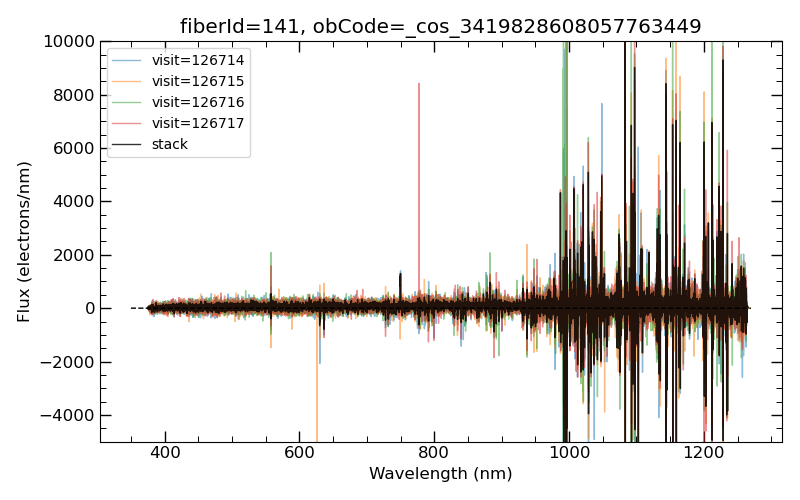

In [14]:
########################################################################
## changing if False you can also specify obCode to show the spectrum ##
########################################################################
if True:
    fiberId = 418
    fiberId = 141
    objId = pfsConfig.select(fiberId=fiberId).objId[0]
    obCode = pfsConfig.select(fiberId=fiberId).obCode[0]
else:
    obCode = "observatoryfiller_ps1dr2_170662156319371979_L"
    fiberId = pfsConfig[pfsConfig.obCode==obCode].fiberId[0]
    objId = pfsConfig[pfsConfig.obCode==obCode].objId[0]


if pfsConfig.obstime[:10] != utc_today:
    print("Please look at visits of today!")
else:
    print(fiberId, objId, obCode)
    fig,axe=plt.subplots(figsize=(8,5), tight_layout=True)
    for visit in visits:
        collections = [os.path.join(baseCollection, f"{visit}")]
        butlerCombine = Butler("/work/datastore", collections=collections)

        pfsConfig = butlerCombine.get("pfsConfig", visit=visit)
        pfsMerged = butlerCombine.get("pfsMerged", visit=visit)
        
        pfsMergedSel = pfsMerged.select(pfsConfig, fiberId=fiberId)
        wav = pfsMergedSel.wavelength[0]
        flx = pfsMergedSel.flux[0]
        msk = pfsMergedSel.mask[0]
        var = pfsMergedSel.variance[0]
        err = np.sqrt(var)
        
        bad = msk & pfsMergedSel.flags.get("NO_DATA", "SAT", "BAD", "CR") != 0
        good = ~bad
        
        axe.set_xlabel(f"Wavelength (nm)")
        axe.set_ylabel(f"Flux (electrons/nm)")
        axe.set_title(f"fiberId={fiberId}, obCode={obCode}")
        axe.plot(wav[good], flx[good], ls="solid", lw=1, alpha=0.5, label=f"visit={visit}")

    pfsMergedStackSel = pfsMergedStack.select(pfsConfig, fiberId=fiberId)
    wav = pfsMergedStackSel.wavelength[0]
    flx = pfsMergedStackSel.flux[0]
    axe.plot(wav, flx, ls="solid", lw=1, color='k', alpha=0.8, label=f"stack")
    
    axe.plot(wav, np.zeros(len(wav)), ls="dashed", lw=1, color="k")    
    axe.set_ylim(-5000, 10000)
    axe.legend(loc="upper left", fontsize=10)